# Peak calling DL model

## Setup

### Create an environment

#### Paste this in your terminal while in this directory and select the 'DL_peak_calling' kernel

```
conda create -n DL_peak_calling -c conda-forge mamba python=3.9 -y && \
conda activate DL_peak_calling && \
mamba env update --file environment.yml
```

### Import and configure libraries

In [19]:
# Erase the .py file in case it already exists
# Line magic function appends the cell to the .py file to be able to launch it distributed in future
! rm --force script.py

In [36]:
%%writefile -a script.py
import sys
import os
import pickle
import json
from time import time, gmtime, strftime, sleep
from collections import Counter
from multiprocessing import Pool

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.image import imread
# Uncomment to use dark plots
# plt.style.use('dark_background')
import seaborn as sns

from IPython.display import clear_output
# Automatically choose based on file type
try:
    get_ipython()
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm
VIOLET = '#ee82ee'

### Set a number of workers

In [21]:
# Specify instead of 'None' if necessary
NUM_WORKERS = None

if not NUM_WORKERS:
    NUM_WORKERS = ! grep -c '^processor' /proc/cpuinfo
    NUM_WORKERS = int(NUM_WORKERS[0])

NUM_WORKERS

96

### Set a device

In [22]:
%%writefile -a script.py


# To manually set a device specify it instead of 'None' (if necessary)
device = torch.device('cuda:1')

# Automatically set a better device
if not device:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up a hyperparameter for distributed training
if device.type == 'cuda':
    world_size = torch.cuda.device_count()

Appending to script.py


## Retrieve the data

#### Retrieve dyad positions

In [32]:
%%bash


for i in 1 2 3
do
    mkdir dataset_${i} -p

    wget \
        https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM256105$((i+6))/suppl/GSM256105$((i+6))%5FDyads%5FH3%5FCC%5Frep%5F${i}%2Ebw \
        -O dataset_${i}/dyads.bw \
        --no-verbose
done

2024-07-17 13:36:59 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561057/suppl/GSM2561057%5FDyads%5FH3%5FCC%5Frep%5F1%2Ebw [10064746/10064746] -> "dataset_1/dyads.bw" [1]
2024-07-17 13:37:02 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561058/suppl/GSM2561058%5FDyads%5FH3%5FCC%5Frep%5F2%2Ebw [8556133/8556133] -> "dataset_2/dyads.bw" [1]
2024-07-17 13:37:04 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561059/suppl/GSM2561059%5FDyads%5FH3%5FCC%5Frep%5F3%2Ebw [7220516/7220516] -> "dataset_3/dyads.bw" [1]


#### Retrieve the [S. cerevisiae (sacCer3) reference genome](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000146045.2/)

In [33]:
! wget \
    https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz \
    -O reference_genome.fasta.gz

! gunzip reference_genome.fasta.gz \
    --force

--2024-07-17 13:38:15--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.7, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3843460 (3.7M) [application/x-gzip]
Saving to: ‘reference_genome.fasta.gz’

reference_genome.fa 100%[===================>]   3.67M  1.63MB/s    in 2.3s    

2024-07-17 13:38:18 (1.63 MB/s) - ‘reference_genome.fasta.gz’ saved [3843460/3843460]



#### Retrieve MNase-Exo-Seq sequence alignment map

In [78]:
%%bash


gdown \
    'https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1' \
    -O exoiii_dataset/exo.bam

samtools \
    view \
    exoiii_dataset/exo.bam > exoiii_dataset/exo.sam

Downloading...
From (original): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1
From (redirected): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1&confirm=t&uuid=52a331a0-b5ee-4400-956f-cb3ed3cdc965
To: /home/v_sidorov/DL_peak_calling/exo.bam
100%|████████████████████████████████████████| 245M/245M [00:21<00:00, 11.3MB/s]


## Analyse the data

### Load the data

#### Load the SAM file

In [111]:
exo_tlens = pd.read_csv(
    'exoiii_dataset/exo.sam',
    sep='\t',
    names=['tlen'],
    usecols=[8],
)

exo_tlens

,tlen
0,117
1,57
2,54
3,-54
4,-57
...,...
8920963,-143
8920964,-85
8920965,-141
8920966,-145


#### Load the dyad probability distributions dictionary

In [105]:
with open('exoiii_dataset/exo_dyad_dists.pickle', 'rb') as file:
    exo_dyad_dists = pickle.load(file)

### Analyse the data

#### Get an MNase-Exo-seq template length distribution

In [119]:
exo_tlen_dist = exo_tlens.tlen
exo_tlen_dist = exo_tlens[exo_tlen_dist.between(0, 200)] \
                                                .groupby(exo_tlen_dist) \
                                                .count()
exo_tlen_dist = exo_tlen_dist.loc[78:]
exo_tlen_dist = exo_tlen_dist / exo_tlen_dist.sum()

exo_tlen_dist

,tlen
tlen,
78,0.000264
79,0.000276
80,0.000303
81,0.000352
82,0.000381
...,...
196,0.000019
197,0.000011
198,0.000015


#### Look at the MNase-Exo-seq template length distribution

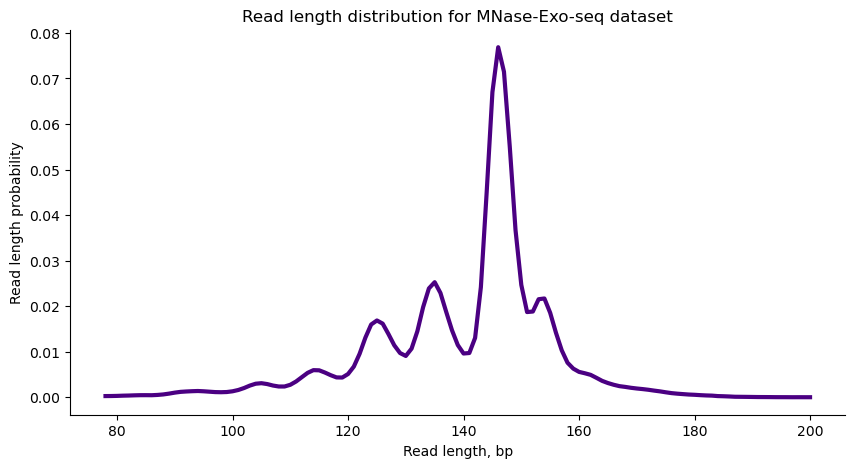

In [140]:
plt.figure(figsize=(10, 5))

ax = sns.lineplot(
    exo_tlen_dist,
    linewidth=3,
    palette=['indigo']
)

plt.title('Read length distribution for MNase-Exo-seq dataset')
plt.xlabel('Read length, bp')
plt.ylabel('Read length probability')
plt.legend([], [], frameon=False)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

#### Define a function to sample a random template length from the MNase-Exo-seq template length distribution

In [26]:
def get_random_tlen():
    '''
    Samples a random template length (78–200 inclusively) from the MNase-Exo-seq template length distribution.
    
    Returns
    -------
    tlen : int
        Template length.
    '''
    tlen =  np.random.choice(
        np.arange(78, 201),
        p=exo_tlen_dist
    )
    
    return tlen

#### Look at a dyad probability distribution at an arbitrary read length

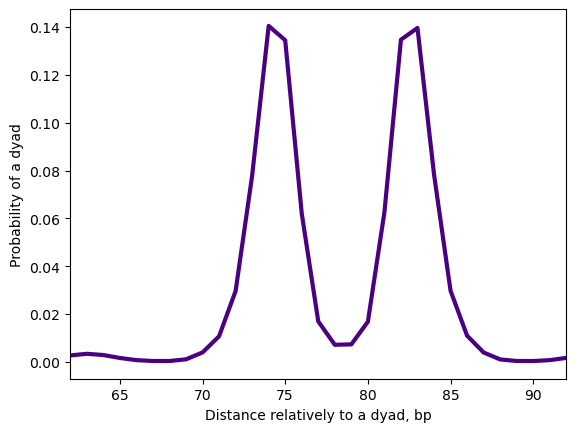

In [136]:
ax = sns.lineplot(
    exo_dyad_dists[157],
    linewidth=3,
    color='indigo'
)

plt.xlim(62, 92)
plt.xlabel('Distance relatively to a dyad, bp')
plt.ylabel('Probability of a dyad')

plt.show()

#### Define a function to sample a random dyad position from the MNase-Exo-seq dyad distribution

In [28]:
def get_random_exo_dyad_pos(length):
    '''
    Samples a random dyad position from an MNase-Exo-seq dyad distribution for a given length.
    
    Parameters
    ----------
    length : int
        Length of the template to sample from.
    
    Returns
    -------
    dyad_pos : int
        Random 1-based position of a dyad on the template of the given length.
    '''
    dyad_pos = np.random.choice(
        np.arange(1, 201),
        p=list(exo_dyad_dists[length])
    )
    
    return dyad_pos

## Prepare a dataset

### Extract dyad positions

#### Convert .bw dyad positions to .bed, removing the first non-informative line

In [29]:
%%bash

for i in 1 2 3
do
    bigWigToBedGraph dataset_${i}/dyads.bw dataset_${i}/dyads.bed

    sed 1d dataset_${i}/dyads.bed > dataset_${i}/dyads_tmp.bed

    mv dataset_${i}/dyads_tmp.bed dataset_${i}/dyads.bed
done

head -n 5 dataset_1/dyads.bed

chrI	32	33	2.572
chrI	33	38	0
chrI	38	39	7.715
chrI	39	66	0
chrI	66	67	12.859


#### Load the dyad positions

In [130]:
def load_dyad_positions(dataset_number):
    raw_dyad_positions = pd.read_csv(
        f'dataset_{dataset_number}/dyads.bed',
        sep='\t',
        usecols=[0, 2, 3],
        names=['chr', 'pos', 'signal']
    )
    return raw_dyad_positions


raw_dyad_positions_1 = load_dyad_positions(1)
raw_dyad_positions_2 = load_dyad_positions(2)
raw_dyad_positions_3 = load_dyad_positions(3)

raw_dyad_positions_1

,chr,pos,signal
0,chrI,33,2.572
1,chrI,38,0.000
2,chrI,39,7.715
3,chrI,66,0.000
4,chrI,67,12.859
...,...,...,...
3383780,chrXVI,948031,0.000
3383781,chrXVI,948032,7.568
3383782,chrXVI,948034,0.000
3383783,chrXVI,948035,5.046


#### Look at signal probability distributions

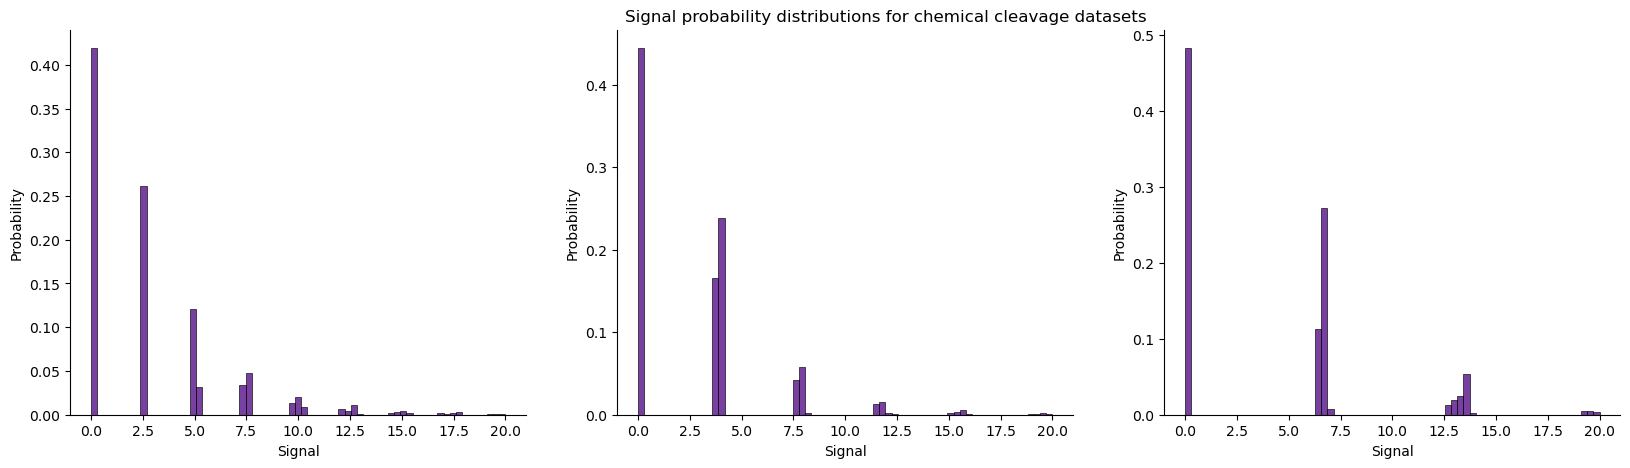

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    sns.histplot(
        eval(f'raw_dyad_positions_{i+1}.signal'),
        binwidth=0.3,
        binrange=(0, 20),
        color='indigo',
        stat='probability',
        ax=ax[i]
    )
    ax[i].set_xlabel('Signal')
    ax[i].set_ylabel('Probability')
    ax[i].spines[['right', 'top']].set_visible(False)

plt.title(
    'Signal probability distributions for chemical cleavage datasets',
    x=-0.61
)

plt.show()

#### Filter rows with low signal

In [32]:
def filter_rows_wo_signal(raw_dyad_positions):
    dyad_positions = raw_dyad_positions \
        .query('signal > 7') \
        .drop('signal', axis=1) \
        .reset_index(drop=True)
    return dyad_positions


dyad_positions_1 = filter_rows_wo_signal(raw_dyad_positions_1)
dyad_positions_2 = filter_rows_wo_signal(raw_dyad_positions_2)
dyad_positions_3 = filter_rows_wo_signal(raw_dyad_positions_3)

dyad_positions_1

,chr,pos
0,chrI,39
1,chrI,67
2,chrI,94
3,chrI,100
4,chrI,129
...,...,...
594211,chrXVI,947724
594212,chrXVI,947817
594213,chrXVI,947840
594214,chrXVI,948030


### Calculate template positions

#### Define a function to get template positions

In [33]:
def get_template_position(center):
    '''
    Calculates start (exclusive) and stop (inclusive) template positions given a center position.
    
    Parameters
    ----------
    center : int
        Dyad position, which will be used to make a template around.
    
    Returns
    -------
    start : int
        Start template position.
    stop : int
        Stop template position.
    '''
    tlen = get_random_tlen()
    dyad_pos = get_random_exo_dyad_pos(tlen)
    start = center - dyad_pos - 1
    stop = start + tlen
    
    return start, dyad_pos, stop

#### Calculate template positions

In [42]:
def calc_template_positions(dyad_positions):
    with Pool(NUM_WORKERS) as pool:
        iterator = pool.imap(get_template_position, dyad_positions['pos'])
        result = np.array(list(tqdm(iterator, total=dyad_positions.shape[0], colour=VIOLET)))
    
    template_positions = pd.DataFrame(dyad_positions[['chr', 'pos']])
    template_positions = template_positions.assign(start=result[:, 0])
    template_positions = template_positions.assign(dyad_pos=result[:, 1])
    template_positions = template_positions.assign(stop=result[:, 2])

    return template_positions


template_positions_1 = calc_template_positions(dyad_positions_1)
template_positions_2 = calc_template_positions(dyad_positions_2)
template_positions_3 = calc_template_positions(dyad_positions_3)

template_positions_1

  0%|          | 0/594216 [00:00<?, ?it/s]

  0%|          | 0/506830 [00:00<?, ?it/s]

  0%|          | 0/323248 [00:00<?, ?it/s]

,chr,pos,start,dyad_pos,stop
0,chrI,39,-37,75,114
1,chrI,67,-9,75,142
2,chrI,94,18,75,169
3,chrI,100,24,75,175
4,chrI,129,53,75,204
...,...,...,...,...,...
594211,chrXVI,947724,947648,75,947794
594212,chrXVI,947817,947743,73,947867
594213,chrXVI,947840,947767,72,947913
594214,chrXVI,948030,947953,76,948082


#### Filter template positions to be inside the reference genome

##### Extract max stop positions

In [54]:
def get_max_stop_positions(template_positions):
    max_positions = template_positions.groupby('chr')['stop'].max() - 200
    
    return max_positions


max_positions_1 = get_max_stop_positions(template_positions_1)
max_positions_2 = get_max_stop_positions(template_positions_2)
max_positions_3 = get_max_stop_positions(template_positions_3)

max_positions_1

chr
chrI        230057
chrII       813028
chrIII      316451
chrIV      1531685
chrIX       439687
chrV        576536
chrVI       269986
chrVII     1090487
chrVIII     562482
chrX        745573
chrXI       666630
chrXII     1077910
chrXIII     924259
chrXIV      784168
chrXV      1091091
chrXVI      947902
Name: stop, dtype: int64

##### Merge template positions with max stop positions, filter, and drop the extra column to bring everything back

In [55]:
def filter_max_stop_positions(template_positions, max_positions):
    filtered_template_positions = pd.merge(
        template_positions,
        max_positions,
        on='chr',
        suffixes=('', '_max')
    )
    filtered_template_positions = filtered_template_positions.query('(start > 0) & (stop < stop_max)')
    filtered_template_positions = filtered_template_positions.drop('stop_max', axis=1)
    
    return filtered_template_positions

filtered_template_positions_1 = filter_max_stop_positions(template_positions_1, max_positions_1)
filtered_template_positions_2 = filter_max_stop_positions(template_positions_2, max_positions_2)
filtered_template_positions_3 = filter_max_stop_positions(template_positions_3, max_positions_3)

filtered_template_positions_1

,chr,pos,start,dyad_pos,stop
2,chrI,94,18,75,169
3,chrI,100,24,75,175
4,chrI,129,53,75,204
5,chrI,133,57,75,208
6,chrI,135,59,75,210
...,...,...,...,...,...
594208,chrXVI,947720,947647,72,947791
594209,chrXVI,947721,947645,75,947760
594210,chrXVI,947722,947646,75,947797
594211,chrXVI,947724,947648,75,947794


### Get dyad positions in the internal templates' reference frames

In [56]:
def get_internal_ref_dyad_positions(filtered_template_positions):
    internal_dyad_positions = filtered_template_positions.dyad_pos.to_numpy()
    
    return internal_dyad_positions


internal_dyad_positions_1 = get_internal_ref_dyad_positions(filtered_template_positions_1)
internal_dyad_positions_2 = get_internal_ref_dyad_positions(filtered_template_positions_2)
internal_dyad_positions_3 = get_internal_ref_dyad_positions(filtered_template_positions_3)

internal_dyad_positions_1

array([75, 75, 75, ..., 75, 75, 73])

#### Cache the dyad positions

In [91]:
def cache_dyad_positions(dataset_number):
    if not os.path.exists(f'dataset_{dataset_number}/cache'):
        os.makedirs(f'dataset_{dataset_number}/cache')
        
    with open(f'dataset_{dataset_number}/cache/internal_dyad_positions.pickle', 'wb') as file:
        pickle.dump(eval(f'internal_dyad_positions_{dataset_number}'), file)


cache_dyad_positions(1)
cache_dyad_positions(2)
cache_dyad_positions(3)

### Get template sequences based on the template positions

#### Substitute 'chr' column values with NCBI identifiers

In [57]:
# Make a dictionary manually using NCBI data
chr_to_id = {
    'chrI': 'NC_001133.9',
    'chrII': 'NC_001134.8',
    'chrIII': 'NC_001135.5',
    'chrIV': 'NC_001136.10',
    'chrV': 'NC_001137.3',
    'chrVI': 'NC_001138.5',
    'chrVII': 'NC_001139.9',
    'chrVIII': 'NC_001140.6',
    'chrIX': 'NC_001141.2',
    'chrX': 'NC_001142.9',
    'chrXI': 'NC_001143.9',
    'chrXII': 'NC_001144.5',
    'chrXIII': 'NC_001145.3',
    'chrXIV': 'NC_001146.8',
    'chrXV': 'NC_001147.6',
    'chrXVI': 'NC_001148.4'
}


def convert_chr_to_id(filtered_template_positions):
    renamed_template_positions = filtered_template_positions.replace(chr_to_id)
    
    return renamed_template_positions


renamed_template_positions_1 = convert_chr_to_id(filtered_template_positions_1)
renamed_template_positions_2 = convert_chr_to_id(filtered_template_positions_2)
renamed_template_positions_3 = convert_chr_to_id(filtered_template_positions_3)

renamed_template_positions_1

,chr,pos,start,dyad_pos,stop
2,NC_001133.9,94,18,75,169
3,NC_001133.9,100,24,75,175
4,NC_001133.9,129,53,75,204
5,NC_001133.9,133,57,75,208
6,NC_001133.9,135,59,75,210
...,...,...,...,...,...
594208,NC_001148.4,947720,947647,72,947791
594209,NC_001148.4,947721,947645,75,947760
594210,NC_001148.4,947722,947646,75,947797
594211,NC_001148.4,947724,947648,75,947794


#### Load template positions into a bedGraph file

In [58]:
def templates_to_bedgraph(renamed_template_positions, dataset_number):
    renamed_template_positions[['chr', 'start', 'stop']].to_csv(
        f'dataset_{dataset_number}/templates.bed',
        sep='\t',
        index=False,
        header=False
    )


templates_to_bedgraph(renamed_template_positions_1, 1)
templates_to_bedgraph(renamed_template_positions_2, 2)
templates_to_bedgraph(renamed_template_positions_3, 3)

! head -n 5 dataset_1/templates.bed

NC_001133.9	18	169
NC_001133.9	24	175
NC_001133.9	53	204
NC_001133.9	57	208
NC_001133.9	59	210


#### Extract sequences from a FASTA file based on positions in bedGraph file

In [59]:
%%bash

for i in 1 2 3
do
    bedtools getfasta \
        -fi reference_genome.fasta \
        -bed dataset_${i}/templates.bed \
        -fo dataset_${i}/templates.fasta
done

rm reference_genome.fasta.fai

head -n 5 dataset_1/templates.fasta

>NC_001133.9:18-169
cccacacaccacaccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATA
>NC_001133.9:24-175
caccacaccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTC
>NC_001133.9:53-204


#### Parse the FASTA file

In [60]:
def parse_fasta_templates(dataset_number):
    fasta_templates = SeqIO.parse(f'dataset_{dataset_number}/templates.fasta', 'fasta')

    templates = list(
        map(
            lambda record: list(str(record.seq).upper()),
            fasta_templates
        )
    )
    
    return templates


templates_1 = parse_fasta_templates(1)
templates_2 = parse_fasta_templates(2)
templates_3 = parse_fasta_templates(3)

print(templates_1[0])

['C', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'T', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'T', 'A', 'C', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'A', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'T', 'C', 'T', 'A', 'A', 'C', 'C', 'C', 'T', 'G', 'G', 'C', 'C', 'A', 'A', 'C', 'C', 'T', 'G', 'T', 'C', 'T', 'C', 'T', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'C', 'C', 'T', 'C', 'C', 'A', 'C', 'T', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'T', 'C', 'C', 'C', 'A', 'T', 'T', 'C', 'A', 'A', 'C', 'C', 'A', 'T', 'A']
CPU times: user 13.3 s, sys: 362 ms, total: 13.6 s
Wall time: 13.8 s


#### Cache the templates

In [86]:
def cache_templates(dataset_number):
    if not os.path.exists(f'dataset_{dataset_number}/cache'):
        os.makedirs(f'dataset_{dataset_number}/cache')
        
    with open(f'dataset_{dataset_number}/cache/templates.pickle', 'wb') as file:
        pickle.dump(eval(f'templates_{dataset_number}'), file)


cache_templates(1)
cache_templates(2)
cache_templates(3)

### Create a dataset and a dataloader

#### Create a one-hot encoded dataset

##### Define the Dataset class

In [23]:
%%writefile -a script.py


class DefaultDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.ohe = {
            'A': torch.tensor([1, 0, 0, 0], dtype=torch.float32),
            'C': torch.tensor([0, 1, 0, 0], dtype=torch.float32),
            'G': torch.tensor([0, 0, 1, 0], dtype=torch.float32),
            'T': torch.tensor([0, 0, 0, 1], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_pos = self.targets[idx]

        # Encode sequence
        encoded_seq = torch.stack([self.ohe[nuc] for nuc in seq])

        # Encode dyad position
        # length = onehot_encoded_seq.shape[0]
        # encoded_dyad_pos = torch.zeros(length)
        # encoded_dyad_pos[dyad_pos] = 1

        return encoded_seq, dyad_pos


class BigramDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_pos = self.targets[idx] - 1

        label_encoded_seq = [self.nuc_to_idx[nuc] for nuc in seq]

        # Create bi-grams
        bigrams = []
        for i in range(len(label_encoded_seq) - 1):
            bigrams.append((label_encoded_seq[i], label_encoded_seq[i+1]))

        # One-hot encode sequence
        one_hot_encoded_seq = []
        for bigram in bigrams:
            one_hot_encoded_seq.append(np.eye(16)[4*bigram[0] + bigram[1]])
        one_hot_encoded_seq = torch.tensor(np.array(one_hot_encoded_seq), dtype=torch.float32)

        # Encode dyad position
        # length = onehot_encoded_seq.shape[0]
        # encoded_dyad_pos = torch.zeros(length)
        # encoded_dyad_pos[dyad_pos] = 1

        return one_hot_encoded_seq, dyad_pos


class TrigramDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_pos = self.targets[idx] - 2

        label_encoded_seq = [self.nuc_to_idx[nuc] for nuc in seq]

        # Create 3-grams
        trigrams = []
        for i in range(len(label_encoded_seq) - 2):
            trigrams.append((label_encoded_seq[i:i+3]))

        # One-hot encode sequence
        one_hot_encoded_seq = []
        for trigram in trigrams:
            trigram_idx = trigram[0] * 16 + trigram[1] * 4 + trigram[2]
            one_hot_encoded_seq.append(np.eye(64)[trigram_idx])
        one_hot_encoded_seq = torch.tensor(np.array(one_hot_encoded_seq), dtype=torch.float32)
        
        # Encode dyad position
        # length = onehot_encoded_seq.shape[0]
        # encoded_dyad_pos = torch.zeros(length)
        # encoded_dyad_pos[dyad_pos] = 1

        return one_hot_encoded_seq, dyad_pos

Appending to script.py


##### Load the templates

In [24]:
%%writefile -a script.py


def load_templates(dataset_number):
    with open(f'dataset_{dataset_number}/cache/templates.pickle', 'rb') as file:
        templates = pickle.load(file)
    
    return templates

Appending to script.py


##### Load the dyad positions

In [25]:
%%writefile -a script.py


def load_internal_dyad_positions(dataset_number):
    with open(f'dataset_{dataset_number}/cache/internal_dyad_positions.pickle', 'rb') as file:
        internal_dyad_positions = pickle.load(file)
    
    return internal_dyad_positions

Appending to script.py


##### Create the dataset

In [26]:
%%writefile -a script.py


def create_dataset(
    templates,
    internal_dyad_positions,
    dataset_prefix,
    dataset_number
    ):
    if dataset_prefix == 'default':
        return DefaultDataset(templates, internal_dyad_positions)
    
    elif dataset_prefix == 'bigram':
        return BigramDataset(templates, internal_dyad_positions)
    
    elif dataset_prefix == 'trigram':
        return TrigramDataset(templates, internal_dyad_positions)

Appending to script.py


#### Split the dataset into training validation and testing sets

In [27]:
%%writefile -a script.py


def split_dataset(dataset):
    # indices = np.random.choice(range(len(dataset)), 100000)
    # dataset = torch.utils.data.Subset(dataset, indices)
    
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    datasets = {}
    datasets['train'], datasets['val'], datasets['test'] = random_split(dataset, [train_size, val_size, test_size])
    
    return datasets

Appending to script.py


#### Define a padding function

In [28]:
%%writefile -a script.py


def pad_collate(batch):
    '''
    Pads a given batch and collates its sequences' lengths to it.
    '''
    # Sort sequences by length to prepare them for the 'pack_padded_sequences' function
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    
    X_batch, y_batch = zip(*batch)
    
    padded_X_batch = pad_sequence(
        X_batch,
        batch_first=True,
        padding_value=-1
    )
    
    lengths = torch.tensor([len(seq) for seq in X_batch])
    
    y_batch = torch.tensor(y_batch)
    
    # padded_y_batch = pad_sequence(
    #     y_batch,
    #     batch_first=True,
    #     padding_value=0
    # )
    
    return padded_X_batch, lengths, y_batch

Appending to script.py


#### Define distributed samplers for multiple GPU usage

In [29]:
%%writefile -a script.py


def create_dist_samplers(dataset, world_size, rank):
    samplers = {}
    
    samplers['train'] = DistributedSampler(dataset['train'], num_replicas=world_size, rank=rank)
    samplers['val'] = DistributedSampler(dataset['val'], num_replicas=world_size, rank=rank)
    samplers['test'] = DistributedSampler(dataset['test'], num_replicas=world_size, rank=rank)
    
    return samplers

Appending to script.py


#### Create dataloaders

In [30]:
%%writefile -a script.py


def create_dataloaders(split_dataset, batch_size, samplers):
    dataloader = {}
    if samplers == None:
        dataloader['train'] = DataLoader(
            split_dataset['train'],
            batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate
        )
        dataloader['val'] = DataLoader(
            split_dataset['val'],
            batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate
        )
        dataloader['test'] = DataLoader(
            split_dataset['test'],
            batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate
        )
        
    else:
        dataloader['train'] = DataLoader(
            split_dataset['train'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate,
            sampler=samplers['train']
        )
        dataloader['val'] = DataLoader(
            split_dataset['val'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate,
            sampler=samplers['val']
        )
        dataloader['test'] = DataLoader(
            split_dataset['test'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            collate_fn=pad_collate,
            sampler=samplers['test']
        )
    
    return dataloader

Appending to script.py


#### Define a function to prepare dataloaders from the raw data

In [31]:
%%writefile -a script.py


def prepare_dataloaders(
    dataset_prefix,
    dataset_number,
    batch_size,
    world_size,
    rank,
    distributed
    ):
    templates = load_templates(dataset_number)
    internal_dyad_positions = load_internal_dyad_positions(dataset_number)
    dataset = create_dataset(templates, internal_dyad_positions, dataset_prefix, dataset_number)
    datasets = split_dataset(dataset)
    samplers = None
    if distributed:
        samplers = create_dist_samplers(datasets, world_size, rank)
    dataloaders = create_dataloaders(datasets, batch_size, samplers)
    
    return dataloaders

Appending to script.py


## Create the model

### Define a model

In [32]:
%%writefile -a script.py


class BiGRUPeakCaller(nn.Module):
    def __init__(self, ngram_symbol_num=1, hidden_size=10, num_layers=1):
        super().__init__()
        
        self.bigru = nn.GRU(
            input_size=4**ngram_symbol_num,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lengths, rank):
        x = pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        x, _ = self.bigru(x)
        x, _ = pad_packed_sequence(x, batch_first=True) # (batch_size, max_len, hidden_size * 2)
        x = self.fc(x).squeeze() # (batch_size, max_len)
        
        # Apply mask to set extra length to negative infinity
        mask = torch.arange(x.shape[1], device=rank)[None, :] < lengths.to(rank)[:, None]
        x = x.masked_fill(~mask, float('-inf'))
        
        x = self.softmax(x)
        
        return x

Appending to script.py


### Train the model

#### Define a train function

In [33]:
%%writefile -a script.py


def train(
    rank=0,
    world_size=1,
    distributed=False,
    args=dict()
    ):
    model = eval(args['model'])
    model_str = args['model']
    hidden_size = int(args['hidden_size'])
    num_layers = int(args['num_layers'])
    loss_fn = eval(args['loss_fn'])
    optimizer = eval(args['optimizer'])
    lr = float(args['lr'])
    weight_decay = float(args['weight_decay'])
    num_epochs = int(args['num_epochs'])
    pred_length = int(args['pred_length'])
    batch_size = int(args['batch_size'])
    dataset_prefix = args['dataset_prefix']
    dataset_number = int(args['dataset_number'])
    run_name = args['run_name']
    
    start_time = time()
    
    torch.cuda.empty_cache()
    
    # Set up distributed processes
    if distributed:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '50000'
        dist.init_process_group(backend='nccl', rank=rank, world_size=world_size)
    else:
        rank = torch.device('cuda:1')

    # Initialize objects
    if dataset_prefix == 'bigram':
        model = model(
            2,
            hidden_size,
            num_layers
        ).to(rank)
    elif dataset_prefix == 'trigram':
        model = model(
            3,
            hidden_size,
            num_layers
        ).to(rank)
    else:
        model = model(
            1,
            hidden_size,
            num_layers
        ).to(rank)
    if distributed:
        model = DDP(model, device_ids=[rank])
    loss_fn = loss_fn()
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    dataloaders = prepare_dataloaders(
        dataset_prefix,
        dataset_number,
        batch_size,
        world_size,
        rank,
        distributed
    )

    train_history = {'loss': [], 'f1': []}
    val_history = {'loss': [], 'f1': []}
    if distributed and rank == 0:
        epoch_pbar = tqdm(
            total=num_epochs,
            desc='Epoch progress',
            colour=VIOLET,
            leave=False
        )
    for epoch in range(1, num_epochs + 1):
        pred_dists = {'train': Counter(), 'val': Counter()}

        model, loss, f1 = train_epoch(
            model,
            hidden_size,
            num_layers,
            loss_fn,
            optimizer,
            lr,
            weight_decay,
            num_epochs,
            pred_length,
            batch_size,
            start_time,
            epoch,
            rank,
            distributed,
            pred_dists,
            dataloaders['train']
        )
        train_history['loss'].append(loss)
        train_history['f1'].append(f1)

        loss, f1 = evaluate(
            model,
            loss_fn,
            num_epochs,
            pred_length,
            epoch,
            rank,
            distributed,
            dataloaders['val'],
            pred_dists
        )
        val_history['loss'].append(loss)
        val_history['f1'].append(f1)

        plot_train_process(
            model_str,
            hidden_size,
            num_layers,
            loss_fn,
            optimizer,
            lr,
            weight_decay,
            num_epochs,
            pred_length,
            batch_size,
            dataset_prefix,
            dataset_number,
            run_name,
            start_time,
            epoch,
            rank,
            distributed,
            train_history,
            val_history,
            pred_dists
        )
        
        if distributed and rank == 0:
            epoch_pbar.update(1)

    # Save the final results
    if rank == 0:
        results = {
            'model_state': model.module.state_dict(),
            'train_history': train_history,
            'val_history': val_history
        }
        torch.save(results, f'results/{run_name}/results.pth')

    if distributed:
        dist.destroy_process_group()


def train_epoch(
        model,
        hidden_size,
        num_layers,
        loss_fn,
        optimizer,
        lr,
        weight_decay,
        num_epochs,
        pred_length,
        batch_size,
        start_time,
        epoch,
        rank,
        distributed,
        pred_dists,
        dataloader
    ):
    model.train()
    
    if distributed and rank == 0:
        step_pbar = tqdm(
            total=len(dataloader),
            desc=f'Training {epoch}/{num_epochs}',
            leave=False
        )
    dyad_counter = Counter()
    batch_history = {'loss': [], 'f1': {'preds': [], 'targets': []}}
    for X_batch, lengths, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(rank), y_batch.to(rank)

        y_proba = model(X_batch, lengths, rank)

        # Collect predictions and targets
        y_pred = y_proba.argmax(dim=1)
        batch_history['f1']['preds'].extend(y_pred.detach().cpu())
        batch_history['f1']['targets'].extend(y_batch.detach().cpu())

        # Calculate loss
        if f'{loss_fn}' == 'WeightedCELoss':
            loss = loss_fn(y_proba, y_batch, lengths, batch_size)
        else:
            loss = loss_fn(y_proba, y_batch)
        batch_history['loss'].append(loss.item())

        # Get predicted dyad distributions
        pred_dists['train'] += get_pred_dist_by_length(
            y_proba,
            lengths,
            pred_length,
            dyad_counter
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if distributed and rank == 0:
            step_pbar.update(1)

    # Get loss values averaged across all batches
    loss = np.mean(batch_history['loss'])
    
    f1 = f1_score(
        batch_history['f1']['preds'],
        batch_history['f1']['targets'],
        average='weighted'
    )
    
    return model, loss, f1


def evaluate(
    model,
    loss_fn,
    num_epochs,
    pred_length,
    epoch,
    rank,
    distributed,
    dataloader,
    pred_dists
    ):
    model.eval()
    
    if distributed and rank == 0:
        step_pbar = tqdm(
            total=len(dataloader),
            desc=f'Evaluating {epoch}/{num_epochs}',
            colour=VIOLET,
            leave=False
        )
    dyad_counter = Counter()
    batch_history = {'loss': [], 'f1': {'preds': [], 'targets': []}}
    with torch.no_grad():
        for X_batch, lengths, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(rank), y_batch.to(rank)
            
            # Get predictions
            y_proba = model(X_batch, lengths, rank)
            
            # Collect predictions and targets
            y_pred = y_proba.argmax(dim=1)
            batch_history['f1']['preds'].extend(y_pred.detach().cpu())
            batch_history['f1']['targets'].extend(y_batch.detach().cpu())
            
            # Calculate loss
            if f'{loss_fn}' == 'WeightedCELoss':
                loss = loss_fn(y_proba, y_batch, lengths, batch_size)
            else:
                loss = loss_fn(y_proba, y_batch)
            batch_history['loss'].append(loss.item())
            
            # Get predicted dyad distributions
            pred_dists['val'] += get_pred_dist_by_length(
                y_proba,
                lengths,
                pred_length,
                dyad_counter
            )
            
            if distributed and rank == 0:
                step_pbar.update(1)
    
    # Get loss values averaged across all batches
    loss = np.mean(batch_history['loss'])
    
    # Calculate F1 score averaged across all batches
    f1 = f1_score(
        batch_history['f1']['preds'],
        batch_history['f1']['targets'],
        average='weighted'
    )
    
    return loss, f1


def plot_train_process(
    model,
    hidden_size,
    num_layers,
    loss_fn,
    optimizer,
    lr,
    weight_decay,
    num_epochs,
    pred_length,
    batch_size,
    dataset_prefix,
    dataset_number,
    run_name,
    start_time,
    epoch,
    rank,
    distributed,
    train_history,
    val_history,
    pred_dists
    ):
    # Set up axes
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplot_mosaic(
        [['top_left', 'top_right'],
         ['bottom_left', 'bottom_right']]
    )
    
    # Plot the loss
    axs['top_left'].plot(
        train_history['loss'],
        color='indigo',
        label='Train'
    )
    axs['top_left'].plot(
        val_history['loss'],
        color='violet',
        label='Validation'
    )
    axs['top_left'].set_xlabel('Epochs')
    axs['top_left'].set_ylabel('Loss')
    axs['top_left'].legend()
    axs['top_left'].spines[['right', 'top']].set_visible(False)
    axs['top_left'].grid(False)
    
    # Plot the F1 score
    axs['top_right'].plot(
        train_history['f1'],
        color='indigo',
        label='Train'
    )
    axs['top_right'].plot(
        val_history['f1'],
        color='violet',
        label='Validation'
    )
    axs['top_right'].set_xlabel('Epochs')
    axs['top_right'].set_ylabel('F1 score')
    axs['top_right'].legend()
    axs['top_right'].spines[['right', 'top']].set_visible(False)
    axs['top_right'].grid(False) 
    
    # Plot the dyad probability distribution
    sns.histplot(
        list(pred_dists['train'].elements()),
        binwidth=1,
        stat='probability',
        color='indigo',
        edgecolor='black',
        linewidth=0.7,
        label='Train',
        ax=axs['bottom_left']
    )
    
    sns.histplot(
        list(pred_dists['val'].elements()),
        binwidth=1,
        stat='probability',
        color='violet',
        edgecolor='black',
        linewidth=0.7,
        label='Validation',
        ax=axs['bottom_left']
    )
    xticklabels = axs['bottom_left'].get_xticklabels()
    axs['bottom_left'].set_xticks(axs['bottom_left'].get_xticks()+0.5)
    axs['bottom_left'].set_xticklabels(xticklabels)
    axs['bottom_left'].set_xlabel('Nucleotide steps, bp')
    axs['bottom_left'].set_ylabel('Dyad probability')
    axs['bottom_left'].legend()
    axs['bottom_left'].spines[['right', 'top']].set_visible(False)
    axs['bottom_left'].grid(False)
    
    # Display information about hyperparameters
    model = str(model).split('(')[0]
    loss_fn = str(loss_fn).split('(')[0]
    optimizer = str(optimizer).split('(')[0]
    lr = f'{lr:e}'.replace('0', '').replace('.', '')
    weight_decay = f'{weight_decay:e}'.replace('0', '').replace('.', '')
    exec_time = round(time() - start_time)
    
    axs['bottom_right'].text(
        x=0.2,
        y=-0.12,
        s=f'''
        • Model: {model}\n
        • Hidden size: {hidden_size}\n
        • Number of recurrent layers: {num_layers}\n
        • Loss function: {loss_fn}\n
        • Optimizer: {optimizer}\n
        • Learning rate: {lr}\n
        • Weight decay: {weight_decay}\n
        • Batch size: {batch_size}\n
        • Dataset: {dataset_prefix}_dataset_{dataset_number}\n\n
                Time running\n
Epoch {epoch}/{num_epochs}, {strftime('%H:%M:%S', gmtime(exec_time))} ({strftime('%H:%M:%S', gmtime(exec_time/epoch))} per epoch)
        ''',
        fontsize='15',
        linespacing = 0.7
    )
    axs['bottom_right'].set_title('Current Hyperparameters', fontsize=18, y=0.95)
    axs['bottom_right'].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    axs['bottom_right'].tick_params(
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    axs['bottom_right'].grid(False)
    
    # Save output
    if rank == 0:
        plt.savefig(f'results/{run_name}/figure.png', dpi=300, bbox_inches='tight')
    
    # Reload the figure after each epoch if in jupyter notebook
    elif not distributed:
        clear_output(wait=True)
        plt.show()


def show_figure(run_name):
    fig, ax = plt.subplots(figsize=(40, 25))

    figure = imread(f'results/{run_name}/figure.png')

    plt.imshow(figure)
    
    plt.axis('off')
    
    clear_output()
    plt.show()


def get_pred_dist_by_length(y_proba, lengths, pred_length, dyad_counter):
    pred_length_indices = torch.argwhere(lengths == pred_length).squeeze()
    dyad_indices = y_proba.argmax(dim=1)[pred_length_indices].squeeze().tolist()
    if isinstance(dyad_indices, int):
        dyad_counter += Counter([dyad_indices])
    else:
        dyad_counter += Counter(dyad_indices)
    
    return dyad_counter


class WeightedCELoss():
    def __call__(self, y_proba, y_true, lengths, batch_size):
        # Calculate weights to penalize predictions quadratically
        max_len = lengths.max()
        indices = torch.arange(max_len, dtype=torch.float32).repeat(batch_size, 1).to(device)
        dyad_indices = y_true.unsqueeze(1).expand(batch_size, max_len).to(device)
        weights = F.mse_loss(indices, dyad_indices, reduction='none')
        
        # Calculate loss
        loss = F.cross_entropy(y_proba, y_true)
        weighted_loss = (loss * weights).mean()
        
        return weighted_loss
    
    def __repr__(self):
        return 'WeightedCELoss'
    

class WeightedMSELoss():
    def __call__(self, y_proba, y_true, lengths, batch_size):
        # Create tensors to caluclate loss between
        max_len = lengths.max()
        indices = torch.arange(max_len, dtype=torch.float32).repeat(batch_size, 1).to(device)
        dyad_indices = y_true.unsqueeze(1).expand(batch_size, max_len).to(device)
        
        # Calculate loss
        loss = F.mse_loss(indices, dyad_indices, reduction='none')
        weighted_loss = (loss * y_proba).mean()
        
        return weighted_loss
    
    def __repr__(self):
        return 'WeightedMSELoss'


def export_args(args):
    run_name = args['run_name']
    
    args_json = json.dumps(args)
    
    if not os.path.exists(f'results/{run_name}'):
        os.makedirs(f'results/{run_name}')
    with open(f'results/{run_name}/args.json', 'w') as file:
        file.write(args_json)


def dist_train(world_size, args):
    distributed = True
    mp.spawn(
        train,
        args=(world_size, distributed, args),
        nprocs=world_size,
        join=True
    )

Appending to script.py


In [53]:
import matplotlib.colors as mcolors

# Имя цвета
color_name = 'indigo'

# Получаем hex-код цвета
hex_color = mcolors.to_hex(color_name)
print(hex_color)
for i in tqdm(range(10), colour='#f0ccff'):
    a = i

#4b0082


  0%|          | 0/10 [00:00<?, ?it/s]

#### Set hyperparameters and train

##### Train locally

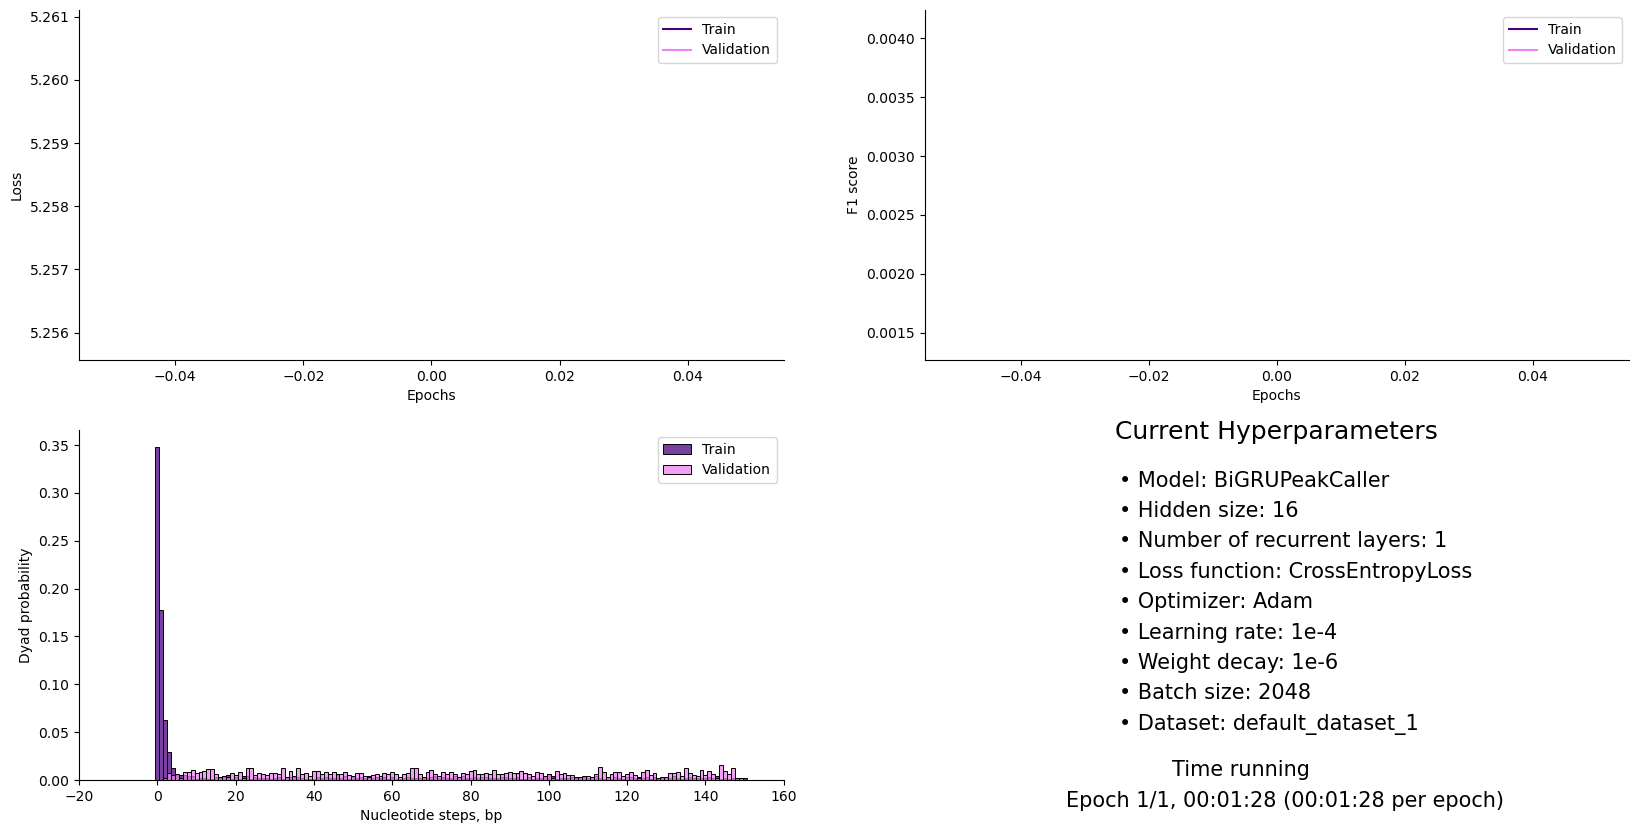

In [105]:
args = {
    'model': 'BiGRUPeakCaller',
    'hidden_size': 16,
    'num_layers': 1,
    'loss_fn': 'nn.CrossEntropyLoss',
    'optimizer': 'optim.Adam',
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'num_epochs': 1,
    'pred_length': 157,
    'batch_size': 2048,
    'dataset_prefix': 'default',
    'dataset_number': 1,
    'run_name': 'test'
}

train(args=args)

##### Train distributed

In [34]:
%%writefile -a script.py


if __name__ == '__main__':
    # Execute only in .py file
    try:
        get_ipython()
    except:
        with open(f'results/{sys.argv[1]}/args.json') as file:
            args = json.loads(file.read())

        dist_train(world_size, args)

Appending to script.py


In [161]:
args = {
    'model': 'BiGRUPeakCaller',
    'hidden_size': 16,
    'num_layers': 1,
    'loss_fn': 'nn.CrossEntropyLoss',
    'optimizer': 'optim.Adam',
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'num_epochs': 1,
    'pred_length': 157,
    'batch_size': 16384,
    'dataset_prefix': 'default',
    'dataset_number': 1,
    'run_name': 'test'
}

export_args(args)

##### Specify the `run_name` and run the following command in your terminal while in this directory

```
python script.py [run_name]
```

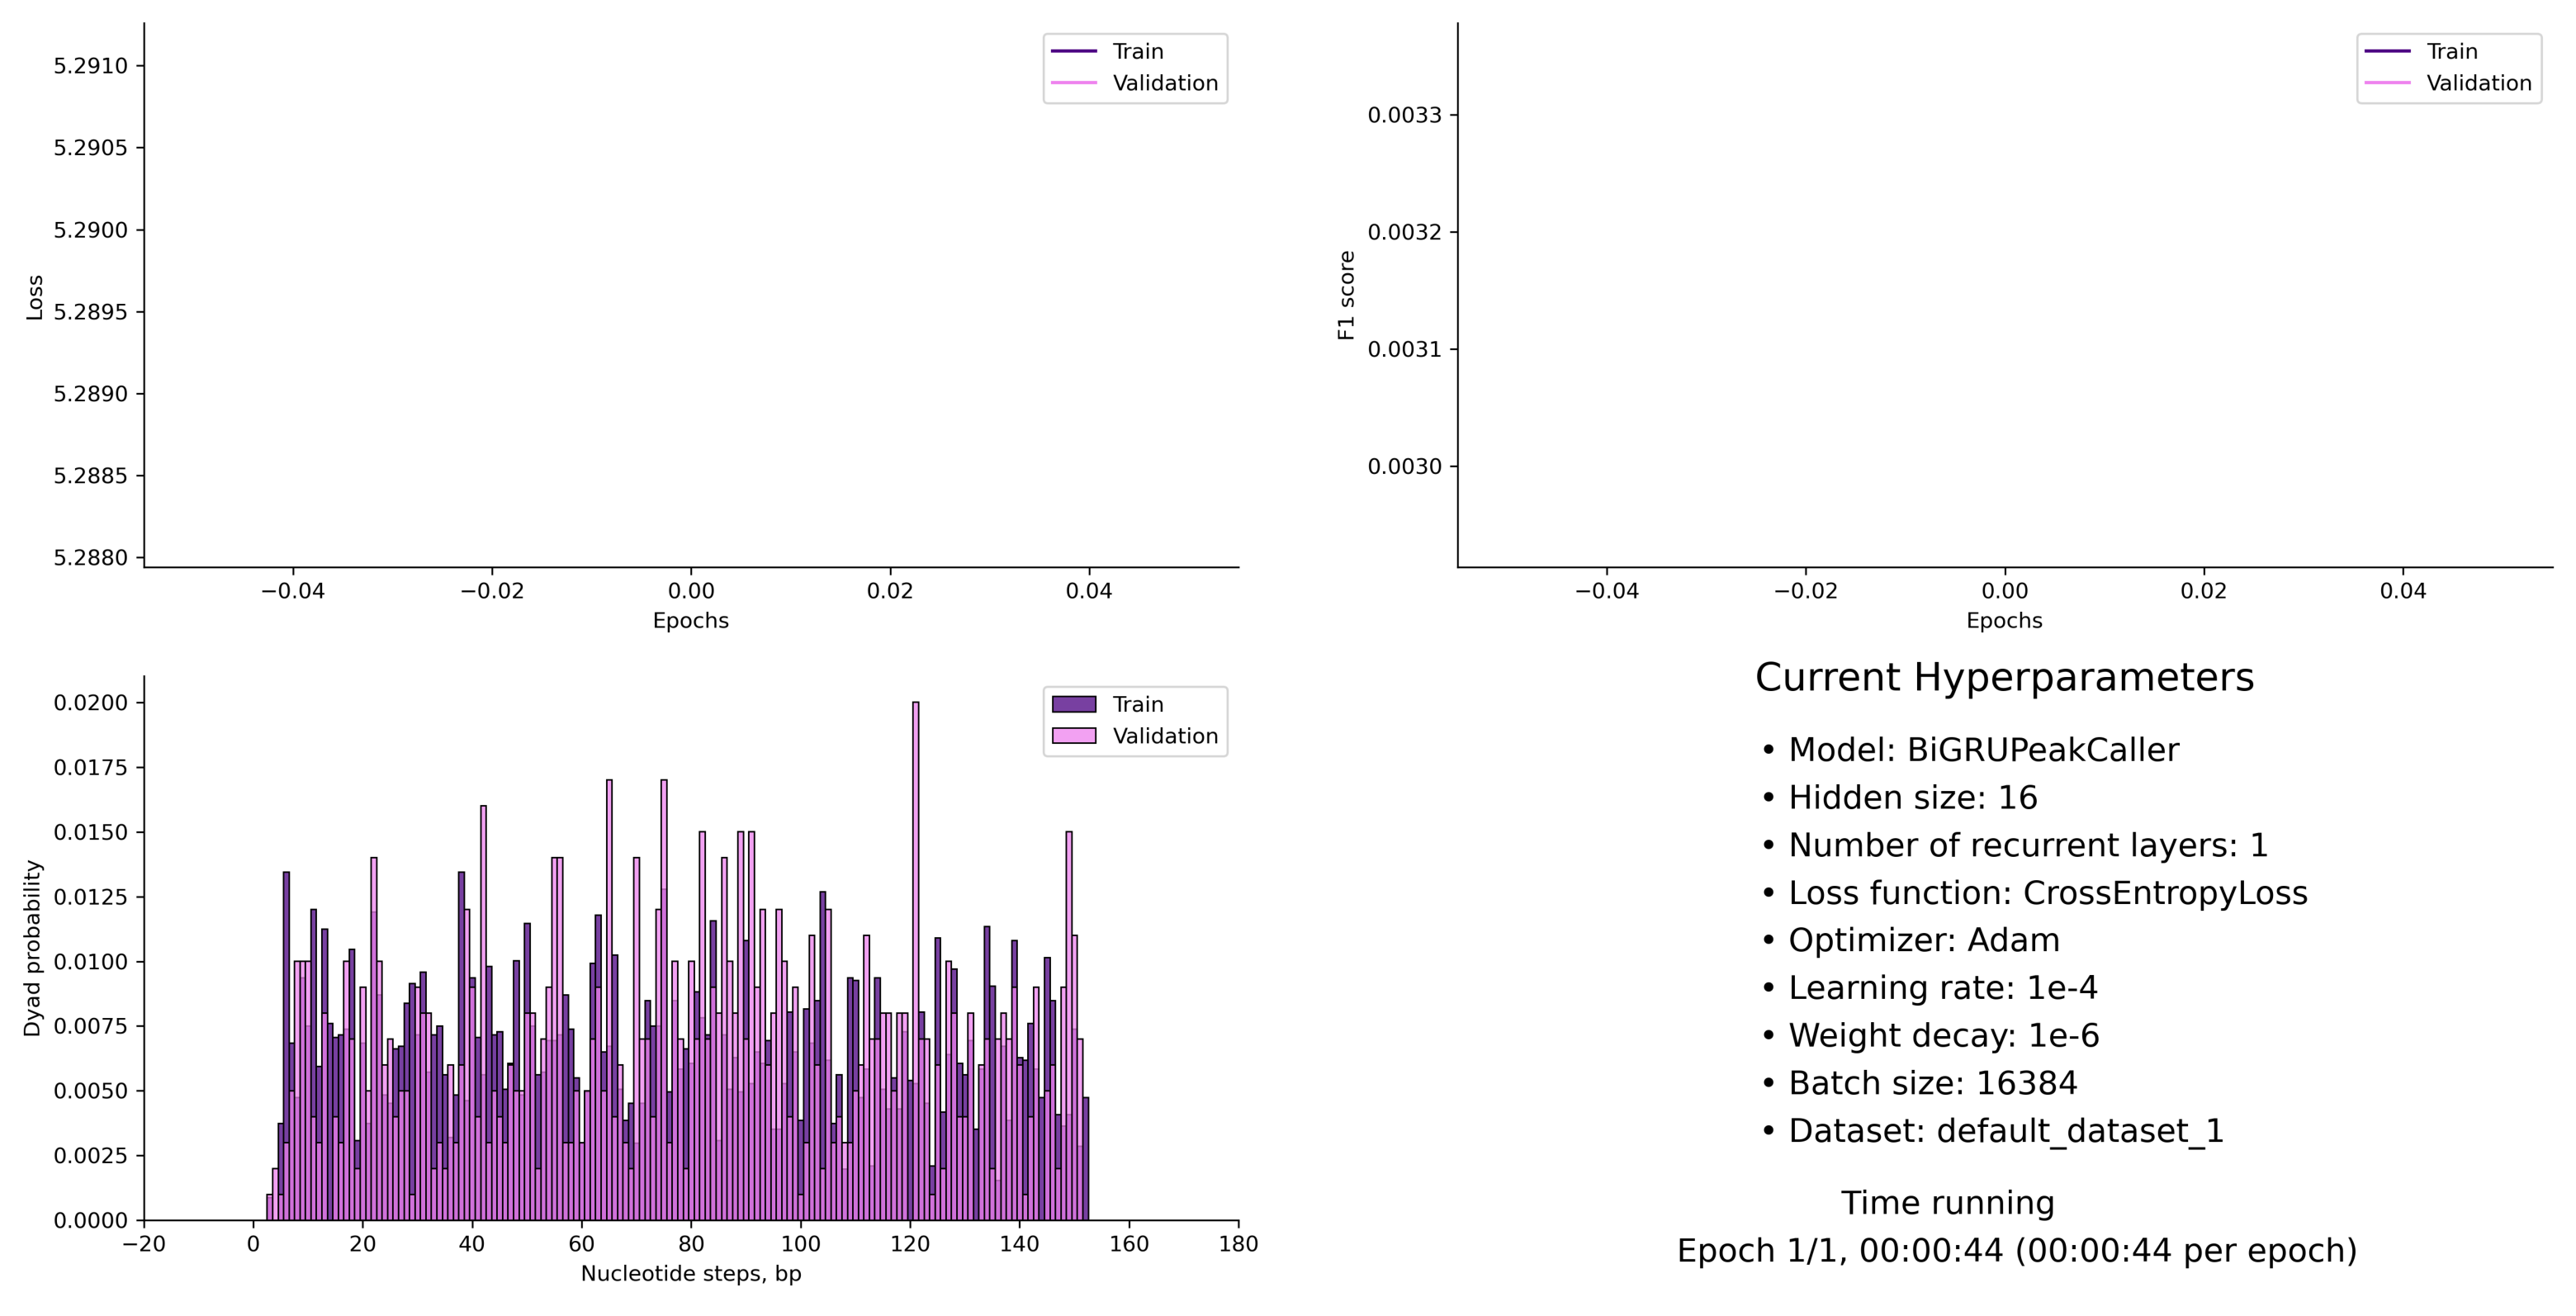

In [198]:
show_figure('test')